# Dicom Pre-Processing

The sources used to process the data:
- [Source 1](https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial)
- [Source 2](https://www.kaggle.com/code/allunia/pulmonary-dicom-preprocessing)
- [Source 3](https://github.com/theodapamede/dicom_preprocessing/blob/main/embed_data_preprocessing/embed_data_preprocessing.ipynb)


In [13]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

Read Files

In [ ]:
def read_dicom(folder_path) -> list[pydicom.FileDataset]:
    dicom_list = glob.glob(f"{folder_path}/*.dcm")
    dicom_list.sort()
    dicom_files = []
    for file in dicom_list:
        dicom_files.append(pydicom.dcmread(file))
    return dicom_files
    

In [3]:
files = read_dicom("../data/raw")

In [5]:
print(len(files))
print(files[0])

626
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.296485632.1.1731597629.926147
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.8
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_368'
-------------------------------------------------
(0008,0000) Group Length                        UL: 216
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.296485632.1.1731597629.926147
(0008,0020) Study Date                          DA: ''
(0

In [11]:
print(files[0].pixel_array.shape)
print(files[0].pixel_array.flatten().shape)
print(files[0].RescaleSlope)
print(files[0].RescaleIntercept)

(512, 512)
(262144,)
1
0


plotting pixel dist

1
0
1
0
1
0
1
0
1
0


Text(0.5, 1.0, 'HU unit distributions for 5 examples')

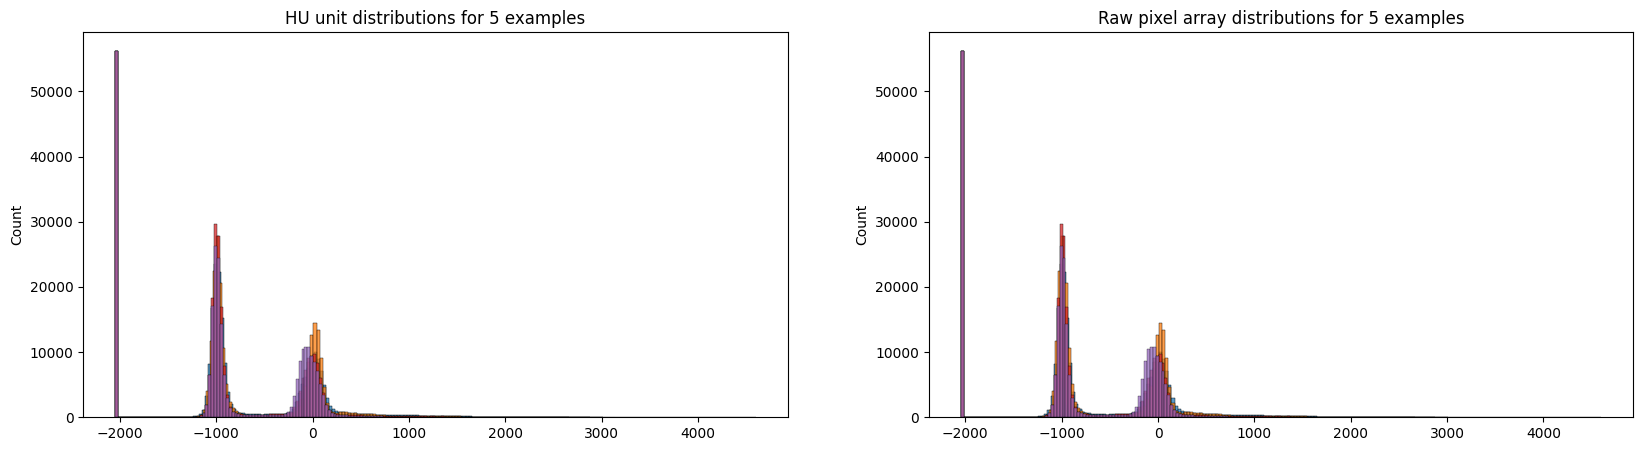

In [22]:
fig,axis = plt.subplots(1,2,figsize=(20,5))
for i in range(10,15):
    img= files[i].pixel_array.flatten()
    print(files[i].RescaleSlope)
    print(files[i].RescaleIntercept)
    scaled = img * files[i].RescaleSlope + files[i].RescaleIntercept
    sns.histplot(scaled.flatten(), ax = axis[0])
    sns.histplot(img.flatten(), ax = axis[1])
axis[1].set_title("Raw pixel array distributions for 5 examples")
axis[0].set_title("HU unit distributions for 5 examples")

### examining the slope and intercept for all files

In [ ]:
inter = set()
slope = set()
cnt = 0
for file in files:
    inter.add(file.RescaleIntercept)
    if file.RescaleIntercept:
        cnt+=1
    slope.add(file.RescaleSlope)

[print(i) for i in inter]
[print(i) for i in slope]
len(inter), len(slope)

0
-1024
1


(2, 1)

In [26]:
set(ds.Modality for ds in files)


{'CT'}

for file i